In [ ]:
!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool

In [ ]:

def get_current_price(symbol):
    ticker = yf.Ticker(symbol)
    todays_data = ticker.history(period='1d')
    return todays_data['Close'][0]


def getData(stocks, start, end):
    stockData = yf.download(stocks, start, end)['Close']
    returns = stockData.pct_change().dropna()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix


def calcWeights(stocks, stock_nos):
  stock_val = np.zeros(shape = (len(stocks)), dtype = np.float32)
  for ind, stock in enumerate(stocks):
    stock_val[ind]=(get_current_price(stock)*stock_nos[ind])
  total_val = np.sum(stock_val)
  return [stock/total_val for stock in stock_val], total_val


def MonteCarlo(weights, meanReturns, total_val, covMatrix, T = 100, mc_sims = 400):
  meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
  meanM = meanM.T
  portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
  portfolio_return_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

  for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)

    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*total_val
    portfolio_return_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*100

  return portfolio_sims, portfolio_return_sims

def VaR(returns, alpha=5):
  return np.percentile(returns, alpha)

def cVaR(returns, alpha=5):
  belowVaR = returns <= VaR(returns, alpha=alpha)
  return returns[belowVaR].mean()

In [ ]:
percent = True
compare_market = False

no_stocks = int(input('Please enter the number of stocks: '))

stockList = []
stock_nos = []
for i in range(no_stocks):
  stock = input('Please Enter NSE Ticker of Stock {:d}: '.format(i+1))
  stockList.append(stock)
  no = int(input('Please Enter No. of shares of {:s} you own: '.format(stock)))
  stock_nos.append(no)
lookback_period = float(input('Please enter the lookback period you wish to use data from (yrs, can be a decimal): '))
mc_sims = int(input('Please enter the number of simulations you wish to run(try to keep under 100,000): '))
T = float(input('Please enter the number of yrs into the future you want to predict portfolio returns (yrs, can be decimal): '))


stocks = [st + '.NS' for st in stockList]
lookback_period = int(lookback_period*365)
T = int(T*365)
if len(stockList)<=1 or compare_market:
  stocks.append('^NSEI')
  stock_nos.append(0)
percent = True

Please enter the number of stocks: 2
Please Enter NSE Ticker of Stock 1: ITC
Please Enter No. of shares of ITC you own: 4
Please Enter NSE Ticker of Stock 2: INFY
Please Enter No. of shares of INFY you own: 9
Please enter the lookback period you wish to use data from (yrs, can be a decimal): 3
Please enter the number of simulations you wish to run(try to keep under 100,000): 1000
Please enter the number of yrs into the future you want to predict portfolio returns (yrs, can be decimal): 2


In [ ]:
end = dt.date.today()
start = end - dt.timedelta(days = lookback_period)
returns, meanReturns, covMatrix = getData(stocks, start, end)
weights, total_val = calcWeights(stocks, stock_nos)
portfolio_vals, portfolio_percents = MonteCarlo(weights, meanReturns, total_val, covMatrix, T, mc_sims)
if(percent):
  results = portfolio_percents[-1, :]
else:
  results = portfolio_vals[-1, :]

[*********************100%***********************]  2 of 2 completed
<ipython-input-3-a084bc5e4dc8>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return todays_data['Close'][0]
<ipython-input-3-a084bc5e4dc8>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return todays_data['Close'][0]


Initial Portfolio Value: Rs. 14997


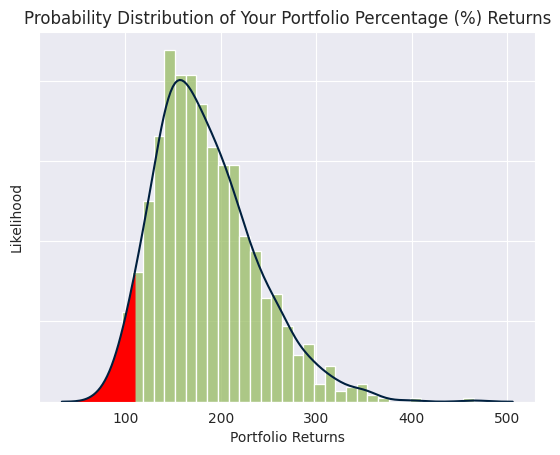

25th Percentile Returns: 145.82 %
Average (50th Percentile) Returns: 176.73 %
75th Percentile Returns: 215.42 %
Variance at Risk: 111.69 %
Conditional Variance at Risk: 99.85 %


In [ ]:

sns.set_style('darkgrid')
ax = sns.histplot(data=results, kde=False, stat='density', bins = 35, fill=True, color = '#97BC62FF')
sns.kdeplot(data=results, color='#00203FFF', ax=ax)
kde_x, kde_y = ax.lines[0].get_data()
x0 = VaR(results)
ax.fill_between(kde_x, kde_y, where=(kde_x<x0) , interpolate=True, color = 'red')
if(not percent):
  ax.set_title("Probability Distribution of Your Portfolio Returns")
else:
  ax.set_title("Probability Distribution of Your Portfolio Percentage (%) Returns")
ax.set(xlabel='Portfolio Returns', ylabel='Likelihood')
ax.set_yticklabels([])
print("Initial Portfolio Value: Rs. {:d}".format(int(total_val)))
plt.show()
if(not percent):
  print("25th Percentile Returns: {:.2f}".format(np.percentile(results, 25)))
  print("Average (50th Percentile) Returns: {:.2f}".format(np.percentile(results, 50)))
  print("75th Percentile Returns: {:.2f}".format(np.percentile(results, 75)))
  print("Variance at Risk: {:.2f}".format(VaR(results)))
  print("Conditional Variance at Risk: {:.2f}".format(cVaR(results)))
else:
  print("25th Percentile Returns: {:.2f} %".format(np.percentile(results, 25)))
  print("Average (50th Percentile) Returns: {:.2f} %".format(np.percentile(results, 50)))
  print("75th Percentile Returns: {:.2f} %".format(np.percentile(results, 75)))
  print("Variance at Risk: {:.2f} %".format(VaR(results)))
  print("Conditional Variance at Risk: {:.2f} %".format(cVaR(results)))

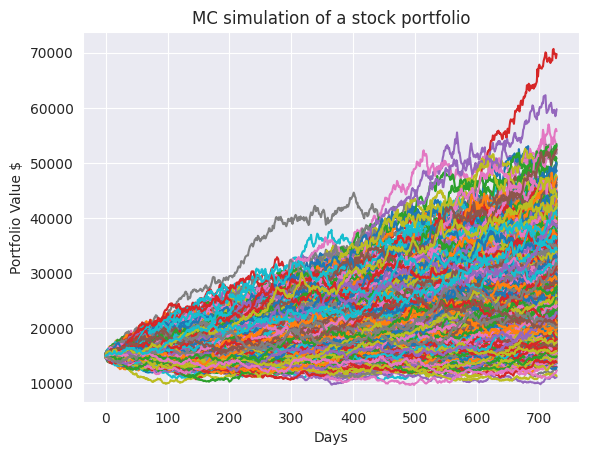

In [ ]:
plt.plot(portfolio_vals)
plt.ylabel('Portfolio Value $')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()